<img src="../images/GA-logo.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Evidence-Based Political Analysis in the Age of Social Media


**Primary Objectives:**

1. Scrape tweets from two Twitter accounts
2. Use NLP to train a classifier to predict the account a given tweet comes from (i.e. binary classification)


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from wordcloud import WordCloud

import re

from data_cleaning import compute_content_length, tokenise, generate_wordcloud, get_sentiment_score

%matplotlib inline

----

## Data Import

In [2]:
# read in the raw data files
tweets_pap_raw = pd.read_csv('../datasets/tweets_pap_raw.csv').drop(columns='Unnamed: 0')
tweets_wp_raw = pd.read_csv('../datasets/tweets_wp_raw.csv').drop(columns='Unnamed: 0')

### Extract Relevant Data Fields

In [3]:
# take a quick look at the dataframe
pd.set_option('display.max_columns', 500)
tweets_pap_raw.head(10)

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,links,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/PAPSingapore/status/143944...,2021-09-19 04:30:00+00:00,What action will you take for her?\n\n#ActionF...,What action will you take for her?\n\n#ActionF...,1439446654180999170,https://twitter.com/PAPSingapore,430,19,113,6,1439446654180999170,en,"<a href=""https://studio.twitter.com"" rel=""nofo...",https://studio.twitter.com,Twitter Media Studio,"[TextLink(text='actionforher.sg', url='http://...",[Video(thumbnailUrl='https://pbs.twimg.com/med...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['ActionForHer', 'PAP4SG']",NaN,NaN,NaN,NaN
1,https://twitter.com/PAPSingapore/status/143843...,2021-09-16 09:30:00+00:00,Go-getter Mavis has no qualms in tailoring her...,Go-getter Mavis has no qualms in tailoring her...,1438434986294759427,https://twitter.com/PAPSingapore,10,11,35,1,1438434986294759427,en,"<a href=""https://studio.twitter.com"" rel=""nofo...",https://studio.twitter.com,Twitter Media Studio,NaN,[Video(thumbnailUrl='https://pbs.twimg.com/med...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['PAP4SG'],NaN,NaN,NaN,NaN
2,https://twitter.com/PAPSingapore/status/143834...,2021-09-16 03:41:35+00:00,Ahead of the PAP Women’s Wing Annual Conferenc...,Ahead of the PAP Women’s Wing Annual Conferenc...,1438347303568375810,https://twitter.com/PAPSingapore,11,15,100,0,1438347303568375810,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"[TextLink(text='tiny.cc/c67juz', url='http://t...",[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,NaN,NaN,"[User(username='PAPSingapore', id=59419156, di...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://twitter.com/PAPSingapore/status/143558...,2021-09-08 12:34:33+00:00,We believe that women in Singapore must be emp...,We believe that women in Singapore must be emp...,1435582327124496390,https://twitter.com/PAPSingapore,16,3,32,2,1435582327124496390,en,"<a href=""https://studio.twitter.com"" rel=""nofo...",https://studio.twitter.com,Twitter Media Studio,NaN,[Video(thumbnailUrl='https://pbs.twimg.com/med...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['PAP4SG'],NaN,NaN,NaN,NaN
4,https://twitter.com/PAPSingapore/status/136635...,2021-03-01 11:35:52+00:00,Our MPs submitted &gt;400 cuts to scrutinise t...,Our MPs submitted &gt;400 cuts to scrutinise t...,1366351477778706436,https://twitter.com/PAPSingapore,114,4,24,0,1366351477778706436,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"[TextLink(text='pap.org.sg/news/pap-mps-a…', u...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['SGBudget2021'],NaN,SummaryCard(title='PAP MPs addressed concerns ...,NaN,NaN
5,https://twitter.com/PAPSingapore/status/135512...,2021-01-29 12:07:38+00:00,We hear you.\n\nOur PAP MPs have filed a motio...,We hear you.\n\nOur PAP MPs have filed a motio...,1355125446426288129,https://twitter.com/PAPSingapore,38,3,28,2,1355125446426288129,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"[TextLink(text='tiny.cc/reibtz', url='http://t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['PAP4Sustainablity', 'GreenSG']",NaN,NaN,NaN,NaN
6,https://twitter.com/PAPSingapore/status/134449...,2020-12-31 04:05:32+00:00,"As we step into the new year, we renew our com...","As we step into the new year, we renew our com...",1344494874528157697,https://twitter.com/PAPSingapore,33,0,42,0,1344494874528157697,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"[TextLink(text='instagram.com/p/CJcevSErpNh', ...",[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['PAP4SG', 'TeamPAP']",NaN,NaN,NaN,NaN
7,https://twitter.com/PAPSingapore/status/131665...,2020-10-15 08:23:02+00:00

In [4]:
# taking a look at all the data fields
tweets_pap_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               2763 non-null   object 
 1   date              2763 non-null   object 
 2   rawContent        2763 non-null   object 
 3   renderedContent   2763 non-null   object 
 4   id                2763 non-null   int64  
 5   user              2763 non-null   object 
 6   replyCount        2763 non-null   int64  
 7   retweetCount      2763 non-null   int64  
 8   likeCount         2763 non-null   int64  
 9   quoteCount        2763 non-null   int64  
 10  conversationId    2763 non-null   int64  
 11  lang              2763 non-null   object 
 12  source            2763 non-null   object 
 13  sourceUrl         2763 non-null   object 
 14  sourceLabel       2763 non-null   object 
 15  links             1030 non-null   object 
 16  media             1411 non-null   object 


Based on the documentation found online, the attributes have the following descriptions:

<img src='../images/snscrape_items.png'>

In [5]:
# define list of data fields to extract for feature engineering
var_list = ['date', # date of tweet is needed for potential stratified sampling later on 
            'rawContent', # rawContent chosen over renderedContent which loses weblinks in the tweet
            'retweetCount', # retweetCount, likeCount and quoteCount give a sense of the level of engagement which is shown to be important
            'likeCount',
            'quoteCount',
            'mentionedUsers', # reflects level of engagement
            'hashtags', # reflects level of engagement
            'links', # links and media reflect the content type
            'media',
            'inReplyToTweetId', # check if it is part of a conversation
            'inReplyToUser',
            'retweetedTweet' # we will use this to filter out retweeted tweets from other accounts to ensure the tweets analysed are only from the specific political party
           ]

In [6]:
# extract selected data fields
tweets_pap = tweets_pap_raw[var_list].copy()
tweets_wp = tweets_wp_raw[var_list].copy()

----

## Data Cleaning

### Impute missing values

In [7]:
tweets_pap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2763 non-null   object 
 1   rawContent        2763 non-null   object 
 2   retweetCount      2763 non-null   int64  
 3   likeCount         2763 non-null   int64  
 4   quoteCount        2763 non-null   int64  
 5   mentionedUsers    377 non-null    object 
 6   hashtags          1538 non-null   object 
 7   links             1030 non-null   object 
 8   media             1411 non-null   object 
 9   inReplyToTweetId  103 non-null    float64
 10  inReplyToUser     103 non-null    object 
 11  retweetedTweet    0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 259.2+ KB


Observations:

- items 5 to 10 have many null values which is not surprising given that these items may not exist in every tweet. For cleaning, we will leave them as blank
- Noting that there are no retweeted Tweets, we will keep all tweets from @PAPSingapore

In [8]:
tweets_wp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2655 non-null   object 
 1   rawContent        2655 non-null   object 
 2   retweetCount      2655 non-null   int64  
 3   likeCount         2655 non-null   int64  
 4   quoteCount        2655 non-null   int64  
 5   mentionedUsers    131 non-null    object 
 6   hashtags          1429 non-null   object 
 7   links             475 non-null    object 
 8   media             774 non-null    object 
 9   inReplyToTweetId  226 non-null    float64
 10  inReplyToUser     226 non-null    object 
 11  retweetedTweet    0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 249.0+ KB


Observations:

- items 5 to 10 have many null values which is not surprising given that these items may not exist in every tweet. For cleaning, we will leave them as blank
- Quick observation here that the number of links and media is much lower for @WPSG compared to @PAPSingapore
- Noting that there are no retweeted Tweets, we will keep all tweets from @PAPSingapore

### Merge the datasets

In [9]:
# create new column for twitter account
tweets_pap.loc[:, 'account'] = 'pap'
tweets_wp.loc[:, 'account'] = 'wp'

# merge dataframes
tweets = pd.concat([tweets_pap, tweets_wp]).reset_index()

In [10]:
tweets.shape

(5418, 14)

### Remove tweets containing non-english words

In [11]:
lang_list = []

for row in tweets['rawContent']:
    try:
        lang = detect(row)
    except:
        lang = 'en'
    lang_list.append(lang)

In [12]:
tweets['lang'] = lang_list

In [13]:
tweets = tweets.loc[tweets['lang'] == 'en', :]

### Convert data types

Only one variable is in the wrong format - `date` will be changed from object to datetime

In [14]:
tweets.loc[:, 'date'] = pd.to_datetime(tweets['date']).dt.tz_localize(None)

### Remove additional characters

There are sometimes additional characters in a tweet that are automatically added (e.g., url to an embedded image) or unicode that do not count towards the Twitter character limit. This will mess with the total normalised character length of the tweet during EDA. As such, we are removing these additional characters and rectifying others.

In [15]:
def replace_characters(row, char_remove, char_add):
    '''
    Function that removes all occurences (including consecutive) of specified characters
    
    '''
    import re
    
    # define all patterns that need to be covered
    # first is sandwiched between non-whitespace
    # second is sandwiched between whitespace and non-whitespace
    # third is sandwiched between non-whitespace and whitespace
    # fourth is sandwiched between whitespace and whitespace
    pattern = fr'(?<=\S){char_remove}+(?=\S)|(?<=\s){char_remove}+(?=\S)|(?<=\S){char_remove}+(?<=\s)|{char_remove}+'
    
    return re.sub(pattern, char_add, row)

In [16]:
# remove \n
tweets['cleanedContent'] = tweets['rawContent'].apply(replace_characters,
                                                  char_remove='\n',
                                                  char_add='')

# replace &amp; with &
tweets['cleanedContent'] = tweets['cleanedContent'].apply(replace_characters,
                                                  char_remove='&amp;',
                                                  char_add='&')

# replace &gt; with >
tweets['cleanedContent'] = tweets['cleanedContent'].apply(replace_characters,
                                                  char_remove='&gt;',
                                                  char_add='>')

# if there are images or videos embedded, remove last URL which is the URL of the image or video
tweets.loc[(tweets['media'].notnull()),'cleanedContent'] = tweets.loc[(tweets['media'].notnull()),'cleanedContent'].str.replace(r'^(.*)https://\S+\s*$',
                                                                 r'\1',
                                                                 regex=True)

### Convert `hashtag` to clean strings separated by whitespace

In [17]:
# convert string of hashtags into list of strings each as one hashtag
# convert all to lowercase
tweets['hashtags'] = tweets['hashtags'].str.lower()
# remove the []s
tweets['hashtags'] = tweets['hashtags'].str.strip('[]')
# remove quotes ''
tweets['hashtags'] = tweets['hashtags'].str.replace("'", "")
# remove whitespace, using replace as strip does not work on some whitespace characters not recognised as whitespace
tweets['hashtags'] = tweets['hashtags'].replace('\s+', '', regex=True)
# replace , with whitespace
tweets['hashtags'] = tweets['hashtags'].str.replace(',', ' ')

### Convert `links` and `media` into values based on type of content

In [18]:
# extract type of links and for each link, create new column
links_type = tweets['links'].str.extract('\[(.*?)\s*\(')[0].dropna().unique()

# count number of links
for link in links_type:
    tweets['num_links_' + link] = tweets['links'].fillna('').str.count(link)

In [19]:
# extract type of links and for each link, create new column
media_type = tweets['media'].str.extract('\[(.*?)\s*\(')[0].dropna().unique()

# count number for each media type
for media in media_type:
    tweets['num_media_' + media] = tweets['media'].fillna('').str.count(media)

### Convert reply to boolean

For simplicity, we are not interested in who the tweet is replying to, but only interested in whether the tweet is part of a reply as an indicator of Level of Engagement. As such, we will generalise the `inReplyToTweetId` and `inReplytoUser` as a single boolean variable

In [20]:
tweets['part_of_convo'] = (tweets['inReplyToTweetId'].notnull() | tweets['inReplyToUser'].notnull())

### Remove retweets

Retweets are posts of content from another Twitter accounts which will not have the same characteristics as content generated by the specified account. As such, we will remove the retweets which can start off with "RT @.." before the implementation of an actual retweet function

In [21]:
tweets = tweets[~tweets['rawContent'].str.startswith('RT @')]

In [22]:
tweets.shape

(5218, 21)

Observation:

- Only a very small proportion (0.5%) of tweets were retweets, as such, no issue with removing them

----

## Exploratory Data Analysis (EDA)

We will take a look at the differences and similarities between the 2 accounts to decide which features to use in building the classifier

In [23]:
# set consistent colours for PAP and WP
account_colors = {'pap': '#E91B1F',
                 'wp': '#003366'}

### `date`

We first take a look at the distribution of tweets over time

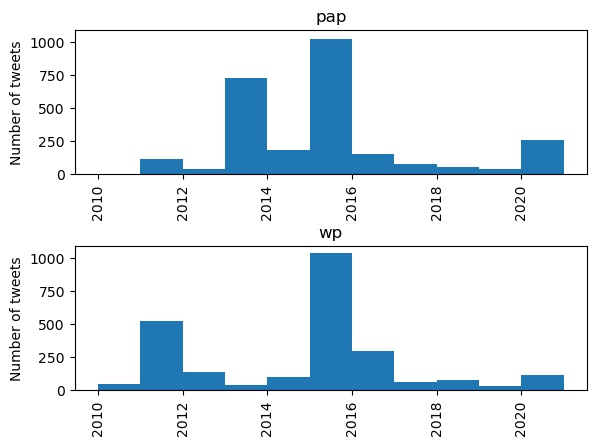

In [24]:
fig, axes = plt.subplots(2,1, sharey=True)

tweets.hist(column='date', by='account', 
            xrot=90, bins=[datetime(year, 1, 1) for year in range(2010,2022)], # generate 1 bin per year
            ax=axes)
axes[0].set_ylabel('Number of tweets')
axes[1].set_ylabel('Number of tweets')

plt.show()

Observation:

- The tweets from both accounts peak around the same periods and coincides with the General Elections (GE) i.e. 2011, 2015 and 2020
- There is also a peak from the PAP account but not the WP acocunt in 2013 which could be explained by the Punggol By-Election and changes to the elected presidency system, both of which generated significant social media chatter
- Given that the majority of tweets for both accounts happen around the same time, we can assume there is a low probability of differences in tweet characteristics due to different time periods. In fact, the accounts are likely to be talking about similar topics which makes it even harder to differentiate the 2 accounts

### Messaging: `rawContent`

Next, we take a look at the actual tweet

In [25]:
pd.set_option('display.max_colwidth', None)
tweets[['cleanedContent', 'account']]

,cleanedContent,account
0,What action will you take for her?#ActionForHer is our invitation to you to stand with our women in Singapore. Together we can empower women to live out their fullest potential and pursue what they want in life. Make a difference today at https://t.co/2Ywp24UUTM#PAP4SG,pap
1,"Go-getter Mavis has no qualms in tailoring her career to match her passions, challenging stereotypes to be at the forefront and break new grounds. When it comes to making choices in life, she echoed MP Yeo Wan Ling’s perspective that there is no one-size-fits-all. #PAP4SG",pap
2,"Ahead of the PAP Women’s Wing Annual Conference this Sat, I met @PAPSingapore women MPs. They told me about their proposals on Women’s Development in SG. I agree with the spirit of these proposals. Advancing women is an impt agenda item for the govt. – LHL https://t.co/RxuBqsGXVI",pap
3,"We believe that women in Singapore must be empowered to live their fullest potential. Just as MP Poh Li San shared in her meeting with former competitor runner, Lossini Jeyapandiyen, we must not let other people put a limit to the goals our women in Singapore have. #PAP4SG",pap
4,"Our MPs submitted >400 cuts to scrutinise the proposed expenditure for #SGBudget2021. Over the next few days, they will be raising concerns and proposals on diverse topics to ensure that Singapore remains a sustainable city with opportunities for all. https://t.co/7ykMedIigW",pap
...,...,...
5411,"Sylvia Lim: WP was not anti-immigration, but had great concerns over the pace, scale and quality of immigration. http://bit.ly/bhYOeA",wp
5412,Come see the Workers' Party logo along with other icons in the 100 icons exhibition in NLB building. http://twitpic.com/ztkku,wp
5413,"Today! ""YouthQuake 6 - The Influence of Online Media on Singaporean Youths"" from 14:30 to 17:00 at WP HQ. http://bit.ly/8Q0Qcr",wp
5414,Sylvia's speech on Statistics Amendment Bill in Parliament today. http://bit.ly/70iCJr,wp


Observation:

- On first glance, PAP's tweets seem much longer than WP's
- Both accounts have urls and hashtags on most tweets, which should be removed from the content and separated into distinct variables
- We will proceed to do a quick look at the word count and character count as a proportion fo the character limit (which was 140 before Nov 2017, and 280 after), including the distributions

In [26]:
# compute number of characters as a proportion of the character limit
# set the date when the tweet character limit changed
date_char_limit = datetime(2017,11,1)

tweets['content_length'] = tweets.apply(compute_content_length,
                                        axis=1,
                                        content_column='cleanedContent',
                                        date_column='date',
                                        date_char_limit=date_char_limit
                                       )

In [27]:
# check out how many tweets surpass the character limit
np.sum(tweets['content_length']>1.0)

13

In [28]:
pd.set_option('display.max_rows', 500)
tweets.loc[tweets['content_length']>1.0, ['cleanedContent', 'date', 'content_length']]

,cleanedContent,date,content_length
2,"Ahead of the PAP Women’s Wing Annual Conference this Sat, I met @PAPSingapore women MPs. They told me about their proposals on Women’s Development in SG. I agree with the spirit of these proposals. Advancing women is an impt agenda item for the govt. – LHL https://t.co/RxuBqsGXVI",2021-09-16 03:41:35,1.003571
125,"@PulseTan @MCCYsg And we have set up mentorship schemes to give youths a leg up. While we believe in meritocracy, i.e. best person getting the spot regardless of family background, we should not apply it blindly and be oblivious to the fact that some have to work that much harder to get there.",2020-06-08 05:13:43,1.050000
129,"@roystontbh Most financial assistance schemes adopt a PCI (Per Capita Income) basis for deciding amount of assistance given. In other words, family income is divided by the number of family members. The lower PCI, the higher the amount of assistance. I believe it is the same basis with FAS.",2020-06-08 05:00:44,1.039286
147,@james_gohjh And many ground-up initiatives (like TeamSingapore athletes with Engineering Good) have provided re-modelled laptops to needy students. A MSF Community Link has been set up to help families in rental flats HOLISTICALLY to UPLIFT families. Do join them as volunteers...,2020-06-08 04:33:36,1.003571
163,"@qazimzim 1000 Digital Ambassadors will go around the whole of Singapore to get seniors to go digital. Subsidized devices and data plans will be provided for low-income seniors. Covid has shown the long term benefit of getting seniors connected online, including access to tele-medicine.",2020-06-08 04:05:52,1.025000
417,MP Dr Intan Mokhtar spoke abt how appropriate work support can help women rejoin the workforce. Watch the clip here: https://t.co/ijfMfkRMqk,2017-04-07 10:00:03,1.007143
436,Stay tuned as we bring you updates from The PAP Conference & Awards 2016. Sec-Gen @leehsienloong will be addressing over 2500 party members.,2016-12-04 00:01:29,1.007143
441,"#ICYMI: Various training programmes & employment policies are in place to help Singaporeans upgrade, up-skill. Read: https://t.co/MNKiCdg980",2016-11-04 13:26:41,1.007143
3011,“There are worries about the spread of COVID-19 and its impact on the economy. The Workers’ Party does not want to partake in speculation. We urge the government to take caution and exercise judiciousness in calling for a GE.” Read the full statement here: https://t.co/zWonwnKiEt,2020-03-15 10:12:28,1.003571
3171,"Leon Perera called attention to the state of the SME sector during the Budget debates, citing plunging net births of companies in Singapore.",2017-03-21 03:42:14,1.007143


Observation:

- No clear reason why these 13 tweets surpass the character limit...
- Will remove them from the analysis, given that it is a very small number

In [29]:
# removing the 13 tweets from the dataset
tweets = tweets[tweets['content_length']<=1.0]

#### Character length

We take a quick look at the shortest and longest tweets from each account

In [30]:
# look at shorest and longest for pap
tweets[tweets['account'] == 'pap'].sort_values(by='content_length', ascending=False)[['cleanedContent', 'account']]

,cleanedContent,account
1531,"""...befitting n poetic, that for one who did not believe in monuments, Mr Lee would become such a great national icon..."" Minister @NgEngHen",pap
2190,"'Mr Low’s latest non-statement addresses none of these serious charges, which therefore stand unrebutted.' - Press... http://t.co/SiCuczNnU8",pap
460,"#ndrsg:We can keep on building something special in SG for many more yrs and let's achieve happiness, prosperity and progress for our nation",pap
1850,"PM @leehsienloong:to senior party supporters: ""Don't worry, we will not write you off. We'll sign you up."" #OurNewWayForeward #PAPConvention",pap
2485,Many thanks to Mdm Lim for creating and donating 100 paintings to raise funds for the President's Challenge #Lawrence http://t.co/yKFVyMHzLD,pap
...,...,...
2751,@dk point noted.,pap
165,https://t.co/hUzXofB83F,pap
356,https://t.co/gRW04SVkB7,pap
279,Happy Father's Day!,pap


Observation:

- Nothing unexpected
- The shortest tweet is blank, likely because it is just an image or video with no text

In [31]:
# look at shorest and longest for wp
tweets[tweets['account'] == 'wp'].sort_values(by='content_length', ascending=False)[['cleanedContent', 'account']]

,cleanedContent,account
4184,"Redzwan Hafidz, Jalan Besar GRC: ""I joined opp bcos I felt that the country I love is moving in the wrong direction."" http://t.co/iz7Ht1LRfn",wp
3781,"Terence Tan, our candidate for Marine Parade GRC, addresses the rally on the issue of caring for our Singaporean core http://t.co/VFqjAJLl04",wp
3677,Bernard:or one where you have a co-creative grassroots where towns and neighbourhoods are co-owned and our heritage protected and preserved?,wp
3967,Leon: PAP likes to accuse WP of claiming credit. But honestly..they are Number 1 - Olympic gold medalists - when it comes to claiming credit,wp
3888,"Urging voters to elect all 28 WP candidates, Gerald: You can be sure the Sun will still rise on Sept 12 & not just because the rooster crows",wp
...,...,...
2967,5. Phase 2 means... 🧐,wp
3427,#Family,wp
3061,#WalkWithUs,wp
2873,Thread ⬇️,wp


Observation:

- Nothing unexpected also
- In contrast with PAP's tweets, the shortest tweets tend to tag another user or express a mood (e.g., via emoji)


#### Word count

In [32]:
tweets['word_count'] = tweets['cleanedContent'].str.split(' ').apply(lambda x: len(x))

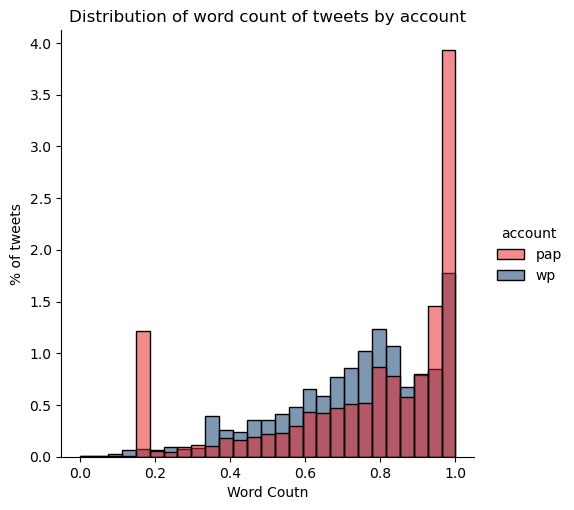

In [33]:
sns.displot(tweets, x='content_length', hue='account', stat='density', palette=account_colors)

plt.xlabel('Word Coutn')
plt.ylabel('% of tweets')
plt.title('Distribution of word count of tweets by account')

plt.show()

Observation:

- Distribution of word count looks generally the same for both accounts, with the exception that PAP's tweets have a sizeable number with very few words
- As such, word count may not be a good feature for prediction

#### Common words and phrases

Before we dive into common words, there are still URLs in the tweets that are not meaningful to consider, as it does not value-add to the messaging of the tweet. In contrast, hashtags still value-add because these reflect the engagement of the account.

As such, we will remove all URLs before examining the common words and phrases.

In [34]:
# remove URLs
tweets['cleanedContent'].replace(r'http\S+', '', regex=True, inplace=True)

# remove hashtags
tweets['cleanedContent'].replace(r'#\S+', '', regex=True, inplace=True)

In [35]:
# tokenise tweets
tweets_pap_tokenised = tokenise(tweets.loc[tweets['account'] == 'pap', 'cleanedContent'])
tweets_wp_tokenised = tokenise(tweets.loc[tweets['account'] == 'wp', 'cleanedContent'])

In [36]:
# generate top 20 words for each account
top20_1gram_pap = tweets_pap_tokenised.sum(axis=0).sort_values(ascending=False).head(20)
top20_1gram_wp = tweets_wp_tokenised.sum(axis=0).sort_values(ascending=False).head(20)

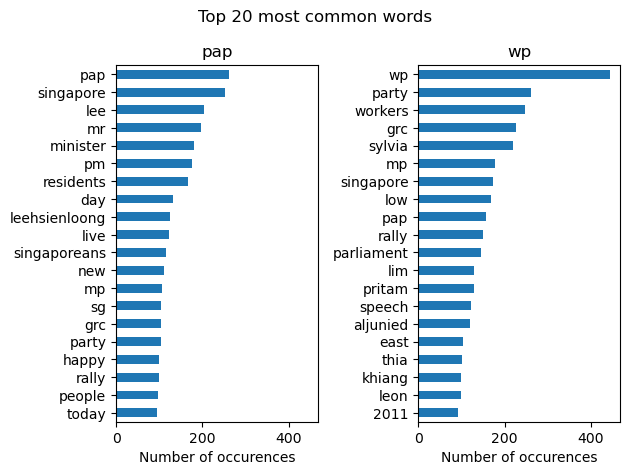

In [37]:
# plot in bar chart
fig, axes = plt.subplots(ncols=2, sharey=False, sharex=True)

top20_1gram_pap.sort_values(ascending=True, inplace=True)
top20_1gram_pap.plot(kind='barh', ax=axes[0],
                     sort_columns=True,
                     title='pap')
axes[0].set_xlabel('Number of occurences')

top20_1gram_wp.sort_values(ascending=True, inplace=True)
top20_1gram_wp.plot(kind='barh', ax=axes[1],
                     sort_columns=True,
                     title='wp')
axes[1].set_xlabel('Number of occurences')

plt.suptitle('Top 20 most common words')

plt.tight_layout()
plt.show()

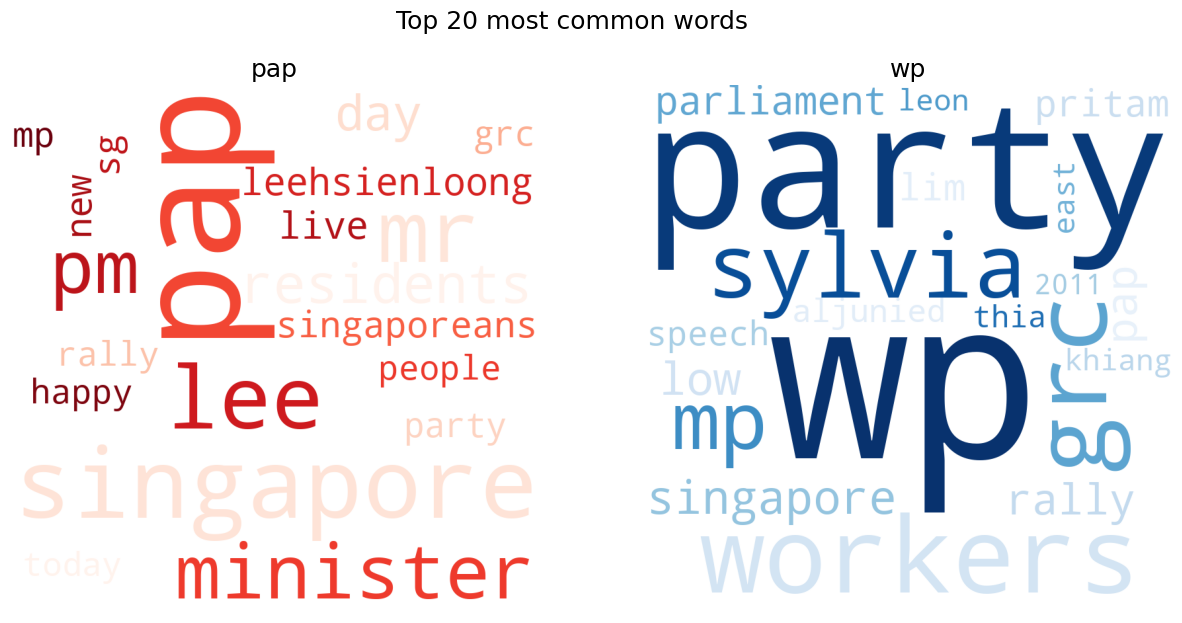

In [38]:
# plot the wordclouds
fig, axes = plt.subplots(ncols=2, figsize=(15,7), facecolor=None)

generate_wordcloud(top20_1gram_pap, axes[0], 'pap', 'Reds')
generate_wordcloud(top20_1gram_wp, axes[1], 'wp', 'Blues')

plt.suptitle('Top 20 most common words', fontsize=18)
 
plt.show()


Observation:

**Similarities**
- Both accounts mention singapore/singaporeans/grc/mp/party/pap very frequently

**Differences**
- Both accounts mention their own party very frequently (e.g., pap and wp)
- While both accounts mention 'mp', it is interesting to note that PAP mentions PM Lee while WP mentions Sylvia Lim, Low Thia Khiang and Pritam Singh
- There are some unique words to each account
    - For PAP, these are minister, live, new, happy, sg
    - For WP, these are rally, sgelections, speech, aljunied
    
Noting that many of the words are part of common phrases (e.g., workers party), we will further examine up to 3-grams.

We also note that there are common words that tend to appear from both accounts. This signals that CountVectorizer may not be the best vectorizer for differentiating the 2 accounts. As such, we will use TF-IDF vectorizer instead to remove these common-to-both-account words.

In [39]:
# tokenise for 2-gram and 3-gram
tweets_pap_tokenised_23grams = tokenise(tweets.loc[tweets['account'] == 'pap', 'cleanedContent'], ngrams=(2,3))
tweets_wp_tokenised_23grams = tokenise(tweets.loc[tweets['account'] == 'wp', 'cleanedContent'], ngrams=(2,3))

In [40]:
# generate top 20 words for each account
top20_23gram_pap = tweets_pap_tokenised_23grams.sum(axis=0).sort_values(ascending=False).head(20)
top20_23gram_wp = tweets_wp_tokenised_23grams.sum(axis=0).sort_values(ascending=False).head(20)

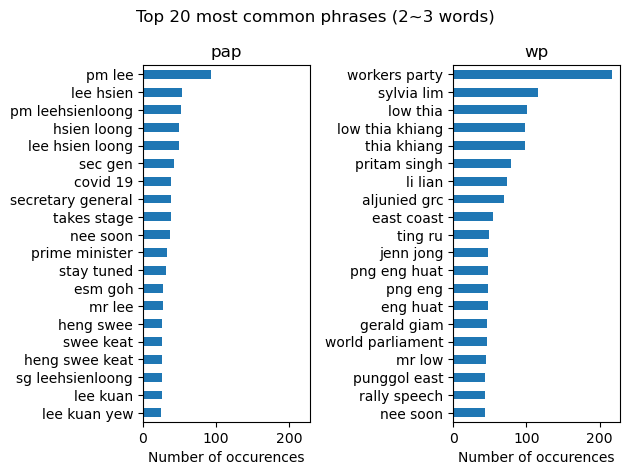

In [41]:
# plot in bar chart
fig, axes = plt.subplots(ncols=2, sharey=False, sharex=True)

top20_23gram_pap.sort_values(ascending=True, inplace=True)
top20_23gram_pap.plot(kind='barh', ax=axes[0],
                     sort_columns=True,
                     title='pap')
axes[0].set_xlabel('Number of occurences')

top20_23gram_wp.sort_values(ascending=True, inplace=True)
top20_23gram_wp.plot(kind='barh', ax=axes[1],
                     sort_columns=True,
                     title='wp')
axes[1].set_xlabel('Number of occurences')

plt.suptitle('Top 20 most common phrases (2~3 words)')

plt.tight_layout()
plt.show()

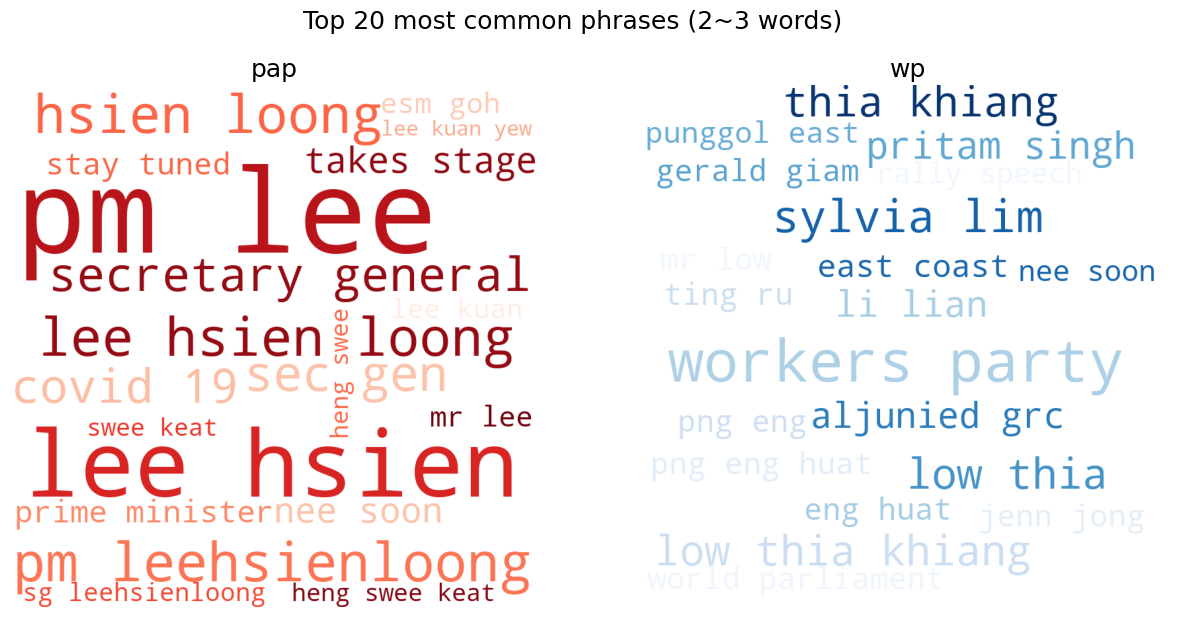

In [42]:
# plot the wordclouds
fig, axes = plt.subplots(ncols=2, figsize=(15,7), facecolor=None)

generate_wordcloud(top20_23gram_pap, axes[0], 'pap', 'Reds')
generate_wordcloud(top20_23gram_wp, axes[1], 'wp', 'Blues')

plt.suptitle('Top 20 most common phrases (2~3 words)', fontsize=18)
 
plt.show()

Observation:

- Unsurprisingly, the phrases from both accounts are dominated by 3 types of items:
    - Mentions of the party's MPs
    - Mentions of some specific GRCs (e.g., nee soon, aljunied)
- Surprisingly, for PAP, some other phrases come to the fore (e.g., covid 19, takes stage, stay tuned); for WP, (e.g., world parliament)
- This signals that 2~3-word phrases may be a good feature for distinguishing the accounts

We will apply TF-IDF on it to remove the similarities

#### Rare words and phrases

After applying TF-IDF vectorizer, we also look at the rare words and phrases that seldom appear that can be removed from the predictor variables to reduce complexity and improve model efficiency (albeit performance may suffer a bit).

In [43]:
tvz = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tvz.fit(tweets.loc[:,'cleanedContent'])
tweets_tokenised_13grams = pd.DataFrame(tvz.transform(tweets.loc[:, 'cleanedContent']).toarray(),
                                columns=tvz.get_feature_names_out()
                               )
tweets_tokenised_13grams['account'] = tweets['account']

In [44]:
tweets_tokenised_13grams_accounts = tweets_tokenised_13grams.groupby('account').max().T

In [45]:
tweets_tokenised_13grams_accounts.describe(np.linspace(0,1,11))

account,pap,wp
count,72212.000000,72212.000000
mean,0.116329,0.096013
std,0.108340,0.115957
min,0.000000,0.000000
0%,0.000000,0.000000
10%,0.000000,0.000000
20%,0.000000,0.000000
30%,0.000000,0.000000
40%,0.000000,0.000000
50%,0.146114,0.000000


Observation:

- Around 50% of words have TF-IDF score of 0. This suggests that a lot of words can be dropped from the model to reduce model complexity without much impact on model performance
- We will do so via the `min_df` to remove words and phrases that appear too infrequently in the tweets

### Messaging: `hashtags`

Another component of messaging is the commonly used hashtags of the account which reflects the causes or main events/entities that the account is trying to publicise. We take a look at these

In [46]:
# evaluate top 20 hashtags for pap and wp
N = 20
hashtags_pap = tweets.loc[tweets['account'] == 'pap', 'hashtags'].str.split(' ').explode().value_counts(ascending=False).head(N)
hashtags_wp = tweets.loc[tweets['account'] == 'wp', 'hashtags'].str.split(' ').explode().value_counts(ascending=False).head(N)

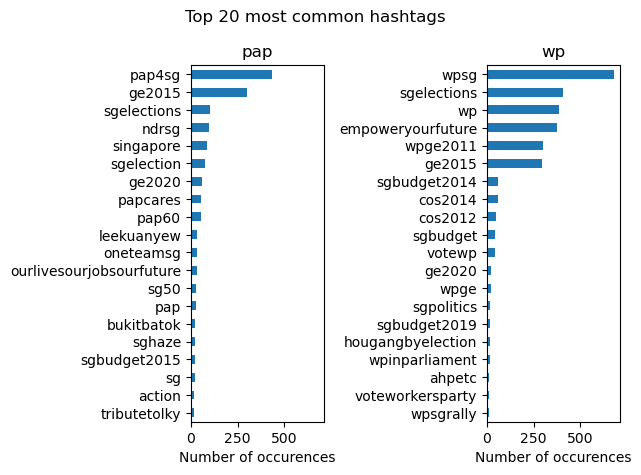

In [47]:
fig, axes = plt.subplots(ncols=2, sharey=False, sharex=True)

hashtags_pap.sort_values(ascending=True, inplace=True)
hashtags_pap.plot(kind='barh', ax=axes[0],
                     sort_columns=True,
                     title='pap')
axes[0].set_xlabel('Number of occurences')

hashtags_wp.sort_values(ascending=True, inplace=True)
hashtags_wp.plot(kind='barh', ax=axes[1],
                     sort_columns=True,
                     title='wp')
axes[1].set_xlabel('Number of occurences')

plt.suptitle('Top 20 most common hashtags')

plt.tight_layout()
plt.show()

Observation:

**Similarities**
- For both accounts, there are fewer than 10 frequently used hashtags (i.e. out of >2,000 tweets for each account, fewer than 10 hashtags appear in at least 10% of the tweets)
- GE2015 is a common frequently used hashtag for both accounts

**Differences**
- Of the frequently used hashtags (i.e. >200 occurences), PAP focuses on pap4sg which is a reference to the party, and WP focuses on wpsg and wp
- WP is more prolific on elections-related (e.g., sgelections, wpge2011) and its slogan of "Empower Your Future" hashtags
- The remaining top 20 hashtags are quite distinct between the 2 accounts

The differences could be used as distinguishing features for the classifier. We are likely to apply TF-IDF on it to remove the similarities

### Tone: `sentiment_score`

To explore the tone of the tweets, we will proxy it with sentiment which is tone on a simplified scale of positive 1.0 to negative 1.0

To analyse sentiment of each tweet, we will use the Valence Aware Dictionary and sEntiment Reasoner (VADER) is a rule-based sentiment analysis tool that is specifically designed for social media text such as tweets

In [49]:
%%time
# compute sentiment scores
tweets['sentiment_score'] = tweets['cleanedContent'].apply(get_sentiment_score)

CPU times: total: 34.8 s
Wall time: 44.4 s


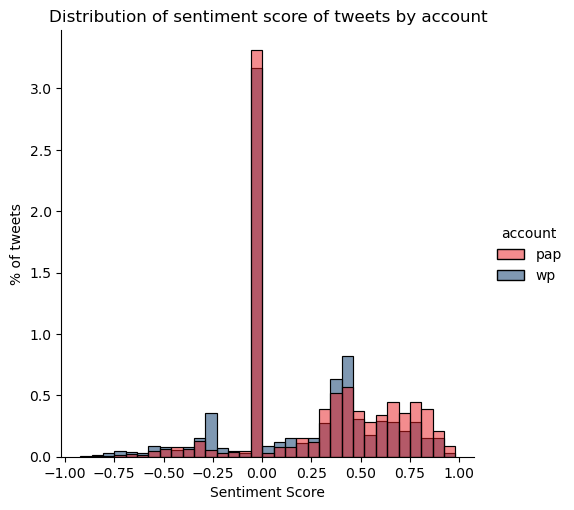

In [50]:
sns.displot(tweets, x='sentiment_score', hue='account', stat='density', palette=account_colors)

plt.xlabel('Sentiment Score')
plt.ylabel('% of tweets')
plt.title('Distribution of sentiment score of tweets by account')

plt.show()

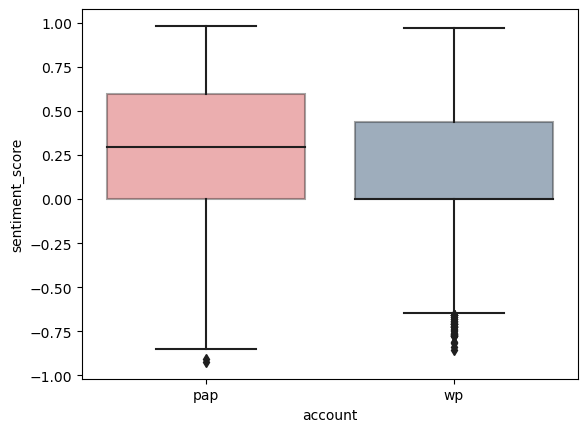

In [51]:
# checking outliers
sns.boxplot(tweets, x='account', y='sentiment_score', 
            palette=account_colors, boxprops=dict(alpha=0.4))

plt.show()

Observation:

- Sentiment score may be of limited value, given that most of the tweets from both accounts have a neutral score
- Nonetheless, PAP's tweets tend to be slight more likely to have a positive sentiment score and WP vice versa with a larger number of outlier on the negative side
- This is also a feature that political analysts will be interested in, as intuitively, opposition parties tend to be more likely to post negative tweets about policies by nature of their position in the political landscape, so we will not remove these outliers

As such, we will still include this in the classifier

### Content Type: `links` and `media`

We look at the type of content used, in terms of the presence of URLs and different types of media

In [52]:
# check number of plots needed
content_type_cols = tweets.columns[tweets.columns.str.startswith('num_')]
len(content_type_cols)

4

In [53]:
content_type_cols

Index(['num_links_TextLink', 'num_media_Video', 'num_media_Photo',
       'num_media_Gif'],
      dtype='object')

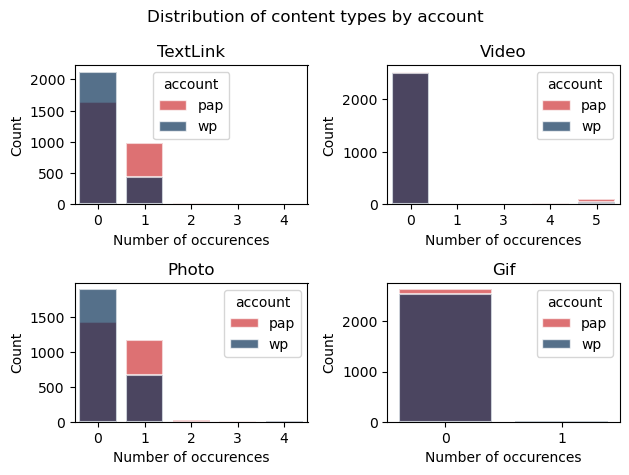

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False)

# plot each content_type in subplot
for i, content_type in enumerate(content_type_cols):
    count = tweets.groupby(['account', content_type])['index'].count().reset_index()

    sns.barplot(data=count, x=content_type, y='index', hue='account', palette=account_colors,
                alpha=0.7, edgecolor='white', dodge=False, ax=axes.flatten()[i])
    plt.setp(axes.flatten()[i].patches, linewidth=1.5)

    axes.flatten()[i].set_ylabel('Count')
    axes.flatten()[i].set_xlabel('Number of occurences')
    axes.flatten()[i].set_title(content_type.split('_')[-1])

plt.suptitle('Distribution of content types by account')

plt.tight_layout()
plt.show()

Observation:

- PAP's tweets are more likely to have a text link or a photo, but there are much smaller difference for video and GIF content types

We will use all 4 features in our classifier

### Level of Engagement: `likeCount`, `quoteCount`, `inReplyToTweetId` and `inReplyToUser`

We look at level of engagement in terms of (a) whether users like or quote the tweets; and (b) whether the account tend to reply to other tweets and users

For simplicity, we will generalise the replies as a boolean variable

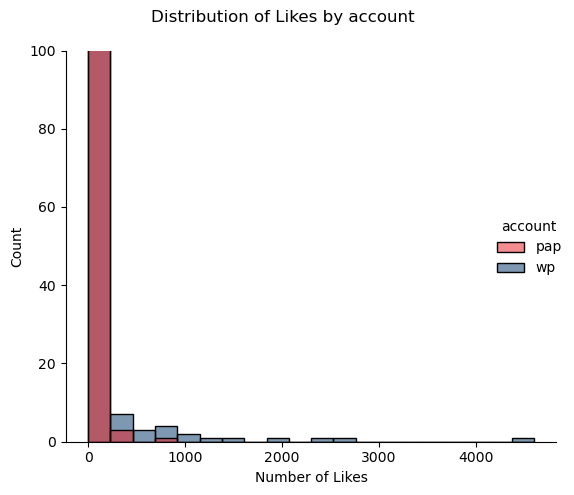

In [56]:
g = sns.displot(tweets, x='likeCount', bins=20, hue='account', palette=account_colors)

plt.ylabel('Count')
plt.xlabel('Number of Likes')

g.set(ylim=(0,100))

plt.suptitle('Distribution of Likes by account')

plt.tight_layout()
plt.show()

Observation:

- While the majority of both accounts' tweets get few likes, there are some WP tweets that have a lot number of likes which will be crucial in differentiating the 2 accounts
- We further note that WP's account has many more outliers with extremely high likeCount, which is not surprising for a social media account
- What is interesting is that PAP's tweets generally have lower level of engagement in terms of likes compared to WP's

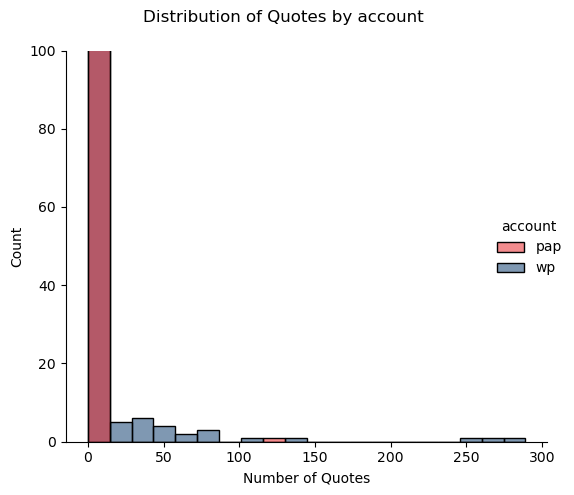

In [57]:
g = sns.displot(tweets, x='quoteCount', bins=20, hue='account', palette=account_colors)

plt.ylabel('Count')
plt.xlabel('Number of Quotes')

g.set(ylim=(0,100))

plt.suptitle('Distribution of Quotes by account')

plt.tight_layout()
plt.show()

Observation:

- We observe a very similar trend of `quoteCount`

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


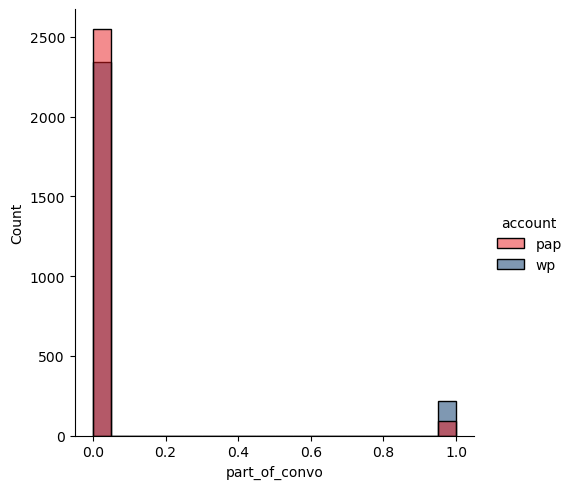

In [58]:
g = sns.displot(tweets, x='part_of_convo', bins=20, hue='account', palette=account_colors)
plt.show()

Observation:

- WP's account is much more likely to reply to tweets and users compared to PAP's account

As such, for the classifier, we will include `likeCount`, `quoteCount` and `part_of_convo`

----

## Clean Data Export

In [59]:
tweets.to_csv('../datasets/tweets_cleaned.csv', index=False)

----

## Specific Plots Formatted for Presentation

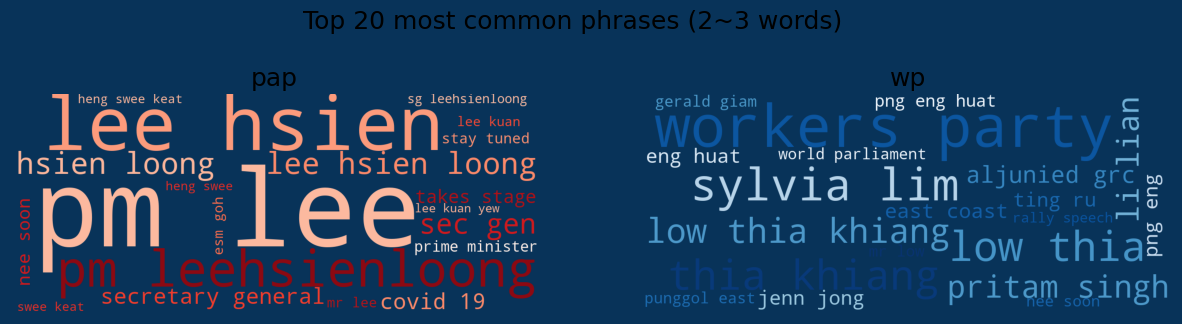

In [60]:
# plot the wordclouds
fig, axes = plt.subplots(ncols=2, figsize=(15,4), facecolor='#083359')

generate_wordcloud(top20_23gram_pap, axes[0], 'pap', 'Reds', '#083359', 1200, 500)
generate_wordcloud(top20_23gram_wp, axes[1], 'wp', 'Blues', '#083359', 1200, 500)

plt.suptitle('Top 20 most common phrases (2~3 words)', fontsize=18)
 
plt.show()

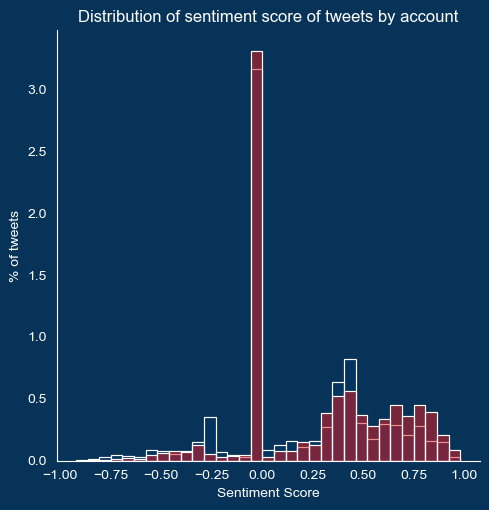

In [63]:
sns.set_style('white')
plt.rcParams['figure.facecolor'] = '#083359'
plt.rcParams['axes.facecolor'] = '#083359'
plt.rcParams['axes.edgecolor'] = 'white'

g = sns.displot(tweets, x='sentiment_score', hue='account', 
            stat='density', palette=account_colors, legend=False)

plt.xlabel('Sentiment Score', color='white')
plt.xticks(color='white')
plt.ylabel('% of tweets', color='white')
plt.yticks(color='white')
plt.title('Distribution of sentiment score of tweets by account', color='white')

plt.show()

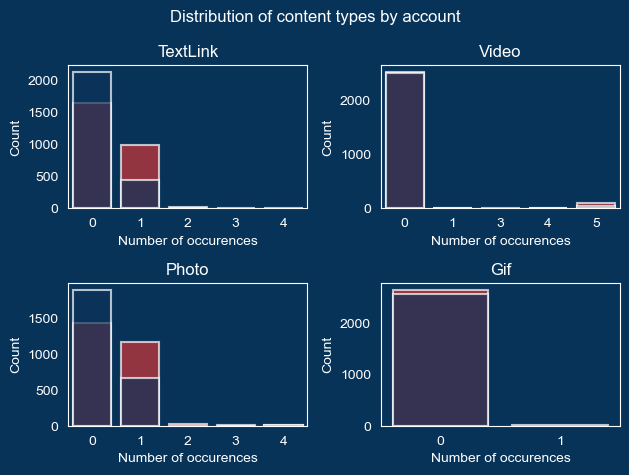

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False)

plt.rcParams['figure.facecolor'] = '#083359'
plt.rcParams['axes.facecolor'] = '#083359'
plt.rcParams['axes.edgecolor'] = 'white'

# plot each content_type in subplot
for i, content_type in enumerate(content_type_cols):
    count = tweets.groupby(['account', content_type])['index'].count().reset_index()

    sns.barplot(data=count, x=content_type, y='index', hue='account', palette=account_colors,
                alpha=0.7, edgecolor='white', dodge=False, ax=axes.flatten()[i])
    plt.setp(axes.flatten()[i].patches, linewidth=1.5)

    axes.flatten()[i].legend_.remove()
    axes.flatten()[i].tick_params(colors='white')
    axes.flatten()[i].set_ylabel('Count', color='white')
    axes.flatten()[i].set_xlabel('Number of occurences', color='white')
    axes.flatten()[i].set_title(content_type.split('_')[-1], color='white')

plt.suptitle('Distribution of content types by account', color='white')

plt.tight_layout()
plt.show()

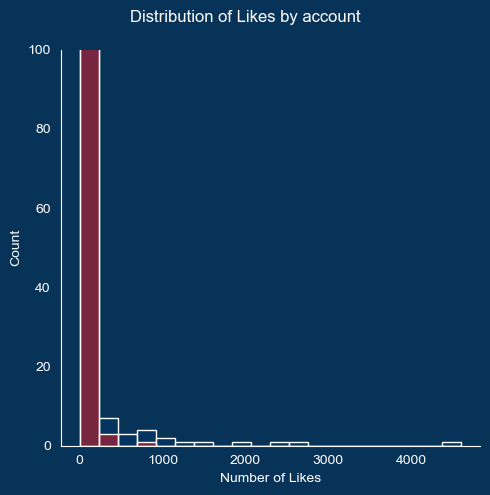

In [65]:
sns.set_style('white')
plt.rcParams['figure.facecolor'] = '#083359'
plt.rcParams['axes.facecolor'] = '#083359'
plt.rcParams['axes.edgecolor'] = 'white'

g = sns.displot(tweets, x='likeCount', bins=20, hue='account', palette=account_colors, legend=False)

plt.xticks(color='white')
plt.ylabel('Count', color='white')
plt.yticks(color='white')
plt.xlabel('Number of Likes', color='white')

g.set(ylim=(0,100))

plt.suptitle('Distribution of Likes by account', color='white')

plt.tight_layout()
plt.show()

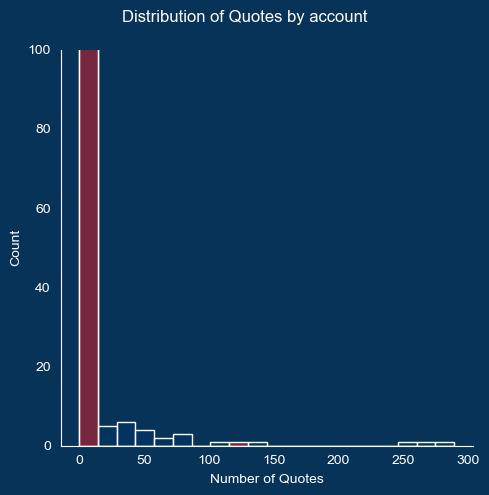

In [66]:
sns.set_style('white')
plt.rcParams['figure.facecolor'] = '#083359'
plt.rcParams['axes.facecolor'] = '#083359'
plt.rcParams['axes.edgecolor'] = 'white'

g = sns.displot(tweets, x='quoteCount', bins=20, hue='account', palette=account_colors, legend=False)

plt.xticks(color='white')
plt.ylabel('Count', color='white')
plt.yticks(color='white')
plt.xlabel('Number of Quotes', color='white')

g.set(ylim=(0,100))

plt.suptitle('Distribution of Quotes by account', color='white')

plt.tight_layout()
plt.show()